In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from utils import automated_pipeline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [8]:
file_raw = r'E:\airta drafts\PREDIKSI KADAR HB\data\raw\erm_hd.xlsx'
df_raw = pd.read_excel(file_raw)

df = automated_pipeline(df_raw)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        643 non-null    int64         
 1   tgl_pemeriksaan  643 non-null    datetime64[ns]
 2   usia             643 non-null    Int64         
 3   jk               643 non-null    Int64         
 4   eritrosit        643 non-null    float64       
 5   hematokrit       643 non-null    float64       
 6   MCHC             643 non-null    float64       
 7   MCH              643 non-null    float64       
 8   MCV              643 non-null    float64       
 9   hemoglobin       643 non-null    float64       
 10  leukosit         643 non-null    Int64         
 11  trombosit        643 non-null    Int64         
 12  epo              643 non-null    Int64         
dtypes: Int64(5), datetime64[ns](1), float64(6), int64(1)
memory usage: 68.6 KB


In [9]:
df = df.sort_values(by=['tgl_pemeriksaan', 'id_pasien']).reset_index(drop=True)

#LAG FEATURE UTAMA
df['hb_now'] = df.groupby('id_pasien')['hemoglobin'].shift(1)

#LAG FEATURE TAMBAHAN
df['hb_lag2'] = df.groupby('id_pasien')['hemoglobin'].shift(2)

#Delta Hb
df['hb_delta'] = df['hb_now'] - df['hb_lag2']

# Rolling mean Hb 2 kunjungan sebelumnya
df['hb_roll2'] = (
    df.groupby('id_pasien')['hemoglobin']
      .shift(1)
      .rolling(2)
      .mean()
)

# Interaksi EPO
df['epo_effect'] = df['epo'] * df['hb_now']

#DROP BARIS DENGAN NILAI NULL PADA LAG FEATURE
lag_cols = ['hb_now', 'hb_lag2', 'hb_roll2', 'hb_delta']
df = df.dropna(subset=lag_cols).reset_index(drop=True)

In [10]:
#MENENTUKAN FITUR X DAN TARGET Y
X = df.drop(columns=['id_pasien', 'tgl_pemeriksaan', 'hemoglobin', 'hematokrit', 'eritrosit'])
y = df['hemoglobin']

#SPLIT 80:20 BERDASARKAN KRONOLOGIS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False
)

print(f"Total baris data: {len(df)}")
print(f"Jumlah Data Latih (80%): {len(X_train)}")
print(f"Jumlah Data Uji (20%): {len(X_test)}")
print("-" * 30)
print("Fitur yang digunakan (X):", X.columns.tolist())

Total baris data: 492
Jumlah Data Latih (80%): 393
Jumlah Data Uji (20%): 99
------------------------------
Fitur yang digunakan (X): ['usia', 'jk', 'MCHC', 'MCH', 'MCV', 'leukosit', 'trombosit', 'epo', 'hb_now', 'hb_lag2', 'hb_delta', 'hb_roll2', 'epo_effect']


In [11]:
# Tabel untuk verifikasi lag feature
lag_table = df[
    ['id_pasien', 'tgl_pemeriksaan', 'hb_now',  'hb_lag2', 'hb_delta', 'hb_roll2', 'epo_effect', 'hemoglobin']
].sort_values(by=['id_pasien', 'tgl_pemeriksaan'])

print(lag_table.head(20))


     id_pasien tgl_pemeriksaan    hb_now   hb_lag2  hb_delta  hb_roll2  \
28           1      2025-05-01  8.100000  8.600000 -0.500000  8.408333   
88           1      2025-06-01  8.300000  8.100000  0.200000  9.050000   
148          1      2025-07-01  7.900000  8.300000 -0.400000  8.308333   
248          1      2025-09-01  7.900000  7.500000  0.400000  7.250000   
296          1      2025-10-01  9.500000  7.900000  1.600000  8.925000   
346          1      2025-11-01  9.100000  9.500000 -0.400000  8.725000   
396          1      2025-12-01  8.700000  9.100000 -0.400000  9.000000   
0            2      2025-04-01  8.300000  7.900000  0.400000  8.450000   
29           2      2025-05-01  7.700000  8.300000 -0.600000  7.900000   
89           2      2025-06-01  7.800000  7.700000  0.100000  8.050000   
149          2      2025-07-01  7.900000  7.800000  0.100000  7.900000   
200          2      2025-08-01  7.200000  7.900000 -0.700000  7.350000   
249          2      2025-09-01  8.0000

In [12]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Cek bagaimana TSCV membagi data X_train kamu
print(f"Total baris di X_train: {len(X_train)}")
print("-" * 30)

for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    print(f"Iterasi ke-{i+1}:")
    print(f"  Jumlah Data Latih: {len(train_index)} baris (Indeks {train_index[0]} s/d {train_index[-1]})")
    print(f"  Jumlah Data Validasi: {len(val_index)} baris (Indeks {val_index[0]} s/d {val_index[-1]})")
    print("-" * 30)

Total baris di X_train: 393
------------------------------
Iterasi ke-1:
  Jumlah Data Latih: 68 baris (Indeks 0 s/d 67)
  Jumlah Data Validasi: 65 baris (Indeks 68 s/d 132)
------------------------------
Iterasi ke-2:
  Jumlah Data Latih: 133 baris (Indeks 0 s/d 132)
  Jumlah Data Validasi: 65 baris (Indeks 133 s/d 197)
------------------------------
Iterasi ke-3:
  Jumlah Data Latih: 198 baris (Indeks 0 s/d 197)
  Jumlah Data Validasi: 65 baris (Indeks 198 s/d 262)
------------------------------
Iterasi ke-4:
  Jumlah Data Latih: 263 baris (Indeks 0 s/d 262)
  Jumlah Data Validasi: 65 baris (Indeks 263 s/d 327)
------------------------------
Iterasi ke-5:
  Jumlah Data Latih: 328 baris (Indeks 0 s/d 327)
  Jumlah Data Validasi: 65 baris (Indeks 328 s/d 392)
------------------------------


In [15]:
df_check = df.copy()
df_check['set'] = 'train'
df_check.loc[X_test.index, 'set'] = 'test'

df_check[['id_pasien', 'tgl_pemeriksaan', 'hb_now', 'hemoglobin', 'set']].iloc[
    len(X_train)-5 : len(X_train)+5
]

,id_pasien,tgl_pemeriksaan,hb_now,hemoglobin,set
388,65,2025-11-01,8.10,6.400000,train
389,67,2025-11-01,6.80,7.666667,train
390,68,2025-11-01,7.30,7.700000,train
391,69,2025-11-01,5.80,7.000000,train
392,71,2025-11-01,8.90,7.100000,train
393,72,2025-11-01,6.00,5.300000,test
394,73,2025-11-01,7.95,8.600000,test
395,75,2025-11-01,9.30,9.800000,test
396,1,2025-12-01,8.70,8.600000,test
397,2,2025-12-01,8.60,8.900000,test


In [17]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

# --- FUNGSI OBJECTIVE UNTUK MASING-MASING MODEL ---

def obj_svr(trial):
    c = trial.suggest_float('C', 0.1, 100.0, log=True)
    epsilon = trial.suggest_float('epsilon', 0.01, 1.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(
            C=c,
            epsilon=epsilon,
            gamma=gamma,
            kernel='rbf'
        ))
    ])

    score = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


def obj_rf(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 15),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        random_state=42
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


def obj_lgbm(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        num_leaves=trial.suggest_int('num_leaves', 20, 100),
        min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 50),
        random_state=42,
        verbose=-1
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()

def obj_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 8),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    )
    return -score.mean()


# --- EKSEKUSI TUNING (Bisa memakan waktu beberapa menit) ---

print("Menjalankan Tuning SVR...")
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(obj_svr, n_trials=30)

print("Menjalankan Tuning Random Forest...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(obj_rf, n_trials=30)

print("Menjalankan Tuning LightGBM...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(obj_lgbm, n_trials=30)

print("Menjalankan Tuning XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(obj_xgb, n_trials=30)

print("\n--- TUNING SELESAI ---")
print(f"SVR MAE: {-study_svr.best_value:.4f}")
print(f"RF MAE: {-study_rf.best_value:.4f}")
print(f"LGBM MAE: {-study_lgbm.best_value:.4f}")
print(f"XGB MAE: {-study_xgb.best_value:.4f}")

[I 2026-02-08 19:46:30,627] A new study created in memory with name: no-name-2cfadfce-35fe-4f24-9e1c-149cfafa2926


Menjalankan Tuning SVR...


[I 2026-02-08 19:46:30,880] Trial 0 finished with value: 0.6757034353499339 and parameters: {'C': 17.82738953067982, 'epsilon': 0.16449602276605194, 'gamma': 0.0005138403802732701}. Best is trial 0 with value: 0.6757034353499339.
[I 2026-02-08 19:46:31,229] Trial 1 finished with value: 0.8728302901975736 and parameters: {'C': 60.87096724618025, 'epsilon': 0.07178775211608816, 'gamma': 0.043699057331657146}. Best is trial 0 with value: 0.6757034353499339.
[I 2026-02-08 19:46:31,479] Trial 2 finished with value: 0.8434445305000935 and parameters: {'C': 58.7492132938469, 'epsilon': 0.1627041731545535, 'gamma': 0.07039677137586467}. Best is trial 0 with value: 0.6757034353499339.
[I 2026-02-08 19:46:31,616] Trial 3 finished with value: 0.7063328819830035 and parameters: {'C': 3.1072028907841416, 'epsilon': 0.3847554713137957, 'gamma': 0.0008553130043337137}. Best is trial 0 with value: 0.6757034353499339.
[I 2026-02-08 19:46:31,743] Trial 4 finished with value: 0.8489344383138213 and param

Menjalankan Tuning Random Forest...


[I 2026-02-08 19:46:37,905] Trial 0 finished with value: 0.6666069510688851 and parameters: {'n_estimators': 127, 'max_depth': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6666069510688851.
[I 2026-02-08 19:46:44,230] Trial 1 finished with value: 0.6734249995557022 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6666069510688851.
[I 2026-02-08 19:46:47,180] Trial 2 finished with value: 0.665298203110055 and parameters: {'n_estimators': 189, 'max_depth': 9, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.665298203110055.
[I 2026-02-08 19:46:50,980] Trial 3 finished with value: 0.6647331399115295 and parameters: {'n_estimators': 266, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.6647331399115295.
[I 2026-02-08 19:46:52,117] Trial 4 finished with value: 0.6656707637262248 and parameters: {'n_estimators': 66, 'max_depth': 7, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.664733139

Menjalankan Tuning LightGBM...


[I 2026-02-08 19:48:36,466] Trial 1 finished with value: 0.7258417590593725 and parameters: {'n_estimators': 53, 'learning_rate': 0.012531067871677688, 'max_depth': 3, 'num_leaves': 92, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.7258417590593725.
[I 2026-02-08 19:48:36,780] Trial 2 finished with value: 0.7095367238764732 and parameters: {'n_estimators': 179, 'learning_rate': 0.061054675784715066, 'max_depth': 9, 'num_leaves': 84, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7095367238764732.
[I 2026-02-08 19:48:36,936] Trial 3 finished with value: 0.7234621719085964 and parameters: {'n_estimators': 159, 'learning_rate': 0.06793653620952879, 'max_depth': 10, 'num_leaves': 69, 'min_data_in_leaf': 41}. Best is trial 2 with value: 0.7095367238764732.
[I 2026-02-08 19:48:37,055] Trial 4 finished with value: 0.7375306250223008 and parameters: {'n_estimators': 80, 'learning_rate': 0.08921422883232404, 'max_depth': 9, 'num_leaves': 25, 'min_data_in_leaf': 48}. Best is tri

Menjalankan Tuning XGBoost...


[I 2026-02-08 19:48:46,523] Trial 0 finished with value: 0.6913087108514248 and parameters: {'n_estimators': 160, 'learning_rate': 0.009566694364760684, 'max_depth': 7, 'subsample': 0.8755060822408997, 'colsample_bytree': 0.7158660522432356}. Best is trial 0 with value: 0.6913087108514248.
[I 2026-02-08 19:48:46,857] Trial 1 finished with value: 0.6746138159140564 and parameters: {'n_estimators': 76, 'learning_rate': 0.038252792559742226, 'max_depth': 4, 'subsample': 0.9835874768135979, 'colsample_bytree': 0.663234564069707}. Best is trial 1 with value: 0.6746138159140564.
[I 2026-02-08 19:48:48,310] Trial 2 finished with value: 0.701209963108943 and parameters: {'n_estimators': 244, 'learning_rate': 0.08789984032860819, 'max_depth': 7, 'subsample': 0.9265517691461365, 'colsample_bytree': 0.8461482193414864}. Best is trial 1 with value: 0.6746138159140564.
[I 2026-02-08 19:48:49,457] Trial 3 finished with value: 0.6824149769709661 and parameters: {'n_estimators': 283, 'learning_rate': 


--- TUNING SELESAI ---
SVR MAE: -0.6534
RF MAE: -0.6487
LGBM MAE: -0.6615
XGB MAE: -0.6672


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Inisialisasi Model Final dengan Best Parameters dari Optuna
models_final = {}

# Linear Regression
models_final["Linear Regression (Baseline)"] = LinearRegression()

# SVR
svr_params = study_svr.best_params
models_final["SVR"] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(
        C=svr_params['C'],
        epsilon=svr_params['epsilon'],
        gamma=svr_params['gamma'],
        kernel='rbf'
    ))
])

# Random Forest
models_final["Random Forest"] = RandomForestRegressor(
    **study_rf.best_params,
    random_state=42
)

# LightGBM
models_final["LightGBM"] = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=42,
    verbose=-1
)

# XGBoost
xgb_params = study_xgb.best_params.copy()
xgb_params['random_state'] = 42
models_final["XGBoost"] = XGBRegressor(**xgb_params)


# 2. Proses Training Final & Evaluasi di Data Test (20%)
final_results = []

for name, model in models_final.items():
    # Training menggunakan 80% data
    model.fit(X_train, y_train)
    
    # Prediksi menggunakan 20% data uji
    y_pred = model.predict(X_test)
    
    # Perhitungan Metrik Evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    final_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

# 3. Menampilkan Tabel Perbandingan Akhir
df_final = pd.DataFrame(final_results).sort_values(by="MAE")
print(df_final)

                          Model       MAE      RMSE        R2
1                           SVR  0.579596  0.752472  0.499450
4                       XGBoost  0.597393  0.772981  0.471793
0  Linear Regression (Baseline)  0.597427  0.769003  0.477216
3                      LightGBM  0.601465  0.788212  0.450772
2                 Random Forest  0.610125  0.777122  0.466119


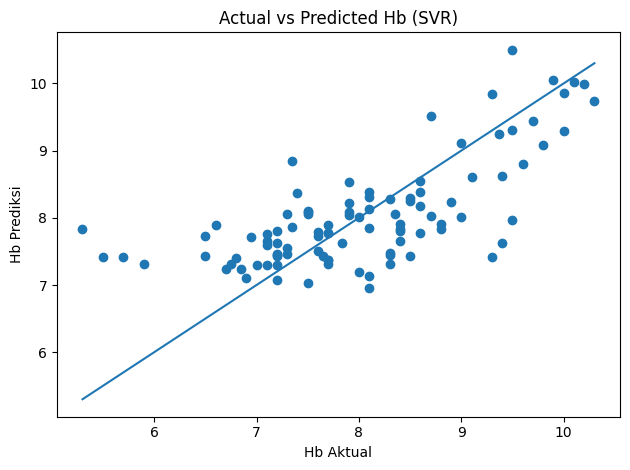

In [20]:
import matplotlib.pyplot as plt

# gunakan model terbaik (SVR)
best_model = models_final["SVR"]

y_pred = best_model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Hb Aktual")
plt.ylabel("Hb Prediksi")
plt.title("Actual vs Predicted Hb (SVR)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.tight_layout()
plt.show()


In [21]:
from sklearn.inspection import permutation_importance

# Analisis untuk SVR
result = permutation_importance(models_final["SVR"], X_test, y_test, n_repeats=10, random_state=42)

importance_svr = pd.DataFrame({
    'Fitur': X_train.columns,
    'Importance_Mean': result.importances_mean
}).sort_values(by='Importance_Mean', ascending=False)

print(importance_svr)

         Fitur  Importance_Mean
8       hb_now         0.238368
9      hb_lag2         0.204341
4          MCV         0.015075
2         MCHC         0.014301
1           jk         0.007357
0         usia         0.006306
3          MCH         0.006204
10    hb_delta         0.005172
6    trombosit         0.003943
12  epo_effect         0.002101
5     leukosit         0.002020
11    hb_roll2         0.001215
7          epo        -0.004252


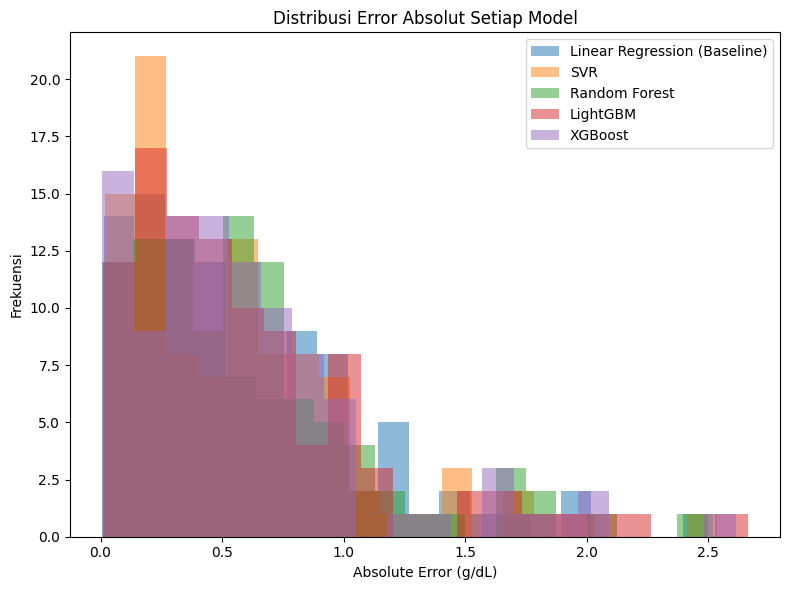

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    abs_error = np.abs(y_test - y_pred)
    
    plt.hist(abs_error, bins=20, alpha=0.5, label=name)

plt.xlabel("Absolute Error (g/dL)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Error Absolut Setiap Model")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Windows\AppData\Local\Temp\ipykernel_11940\3502629487.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors, labels=models_final.keys(), showfliers=False)


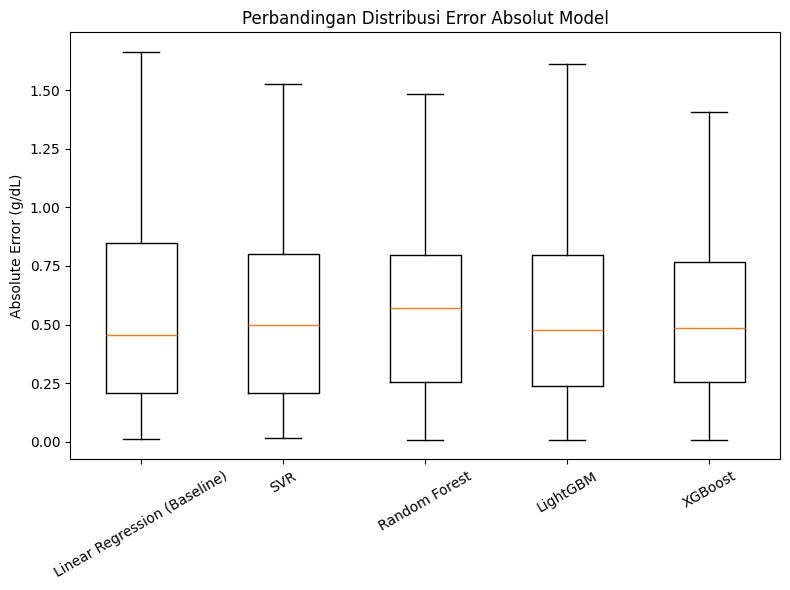

In [23]:
errors = []

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    abs_error = np.abs(y_test - y_pred)
    errors.append(abs_error)

plt.figure(figsize=(8,6))
plt.boxplot(errors, labels=models_final.keys(), showfliers=False)
plt.ylabel("Absolute Error (g/dL)")
plt.title("Perbandingan Distribusi Error Absolut Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
